# Neural Network from scratch

In this lab, we will implement a simple 3-layer neural network from scratch.

In [6]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset using [scikit-learn](http://scikit-learn.org/). We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

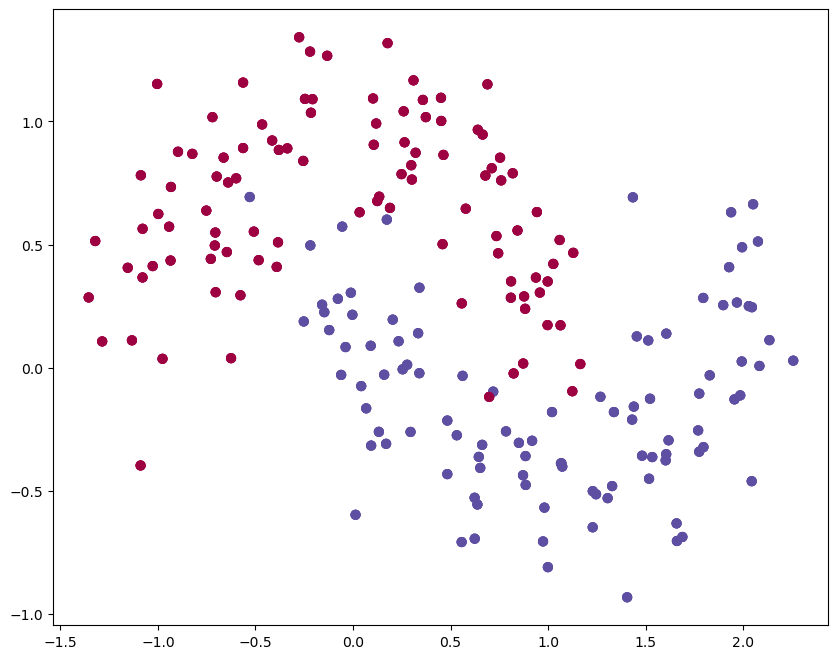

In [11]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as linear Logistic Regression, won't be able to fit the data.

## Practice 1: Logistic Regression

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). 

In [11]:
# Train the logistic regression model with l2 penalty, using 10-fold cross-validation to select the best regularization parameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {"C": np.logspace(-3,3,7)}
## start your code here
model = LogisticRegression(penalty='l1',solver='liblinear')
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X, y)
## end your code here

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [12]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

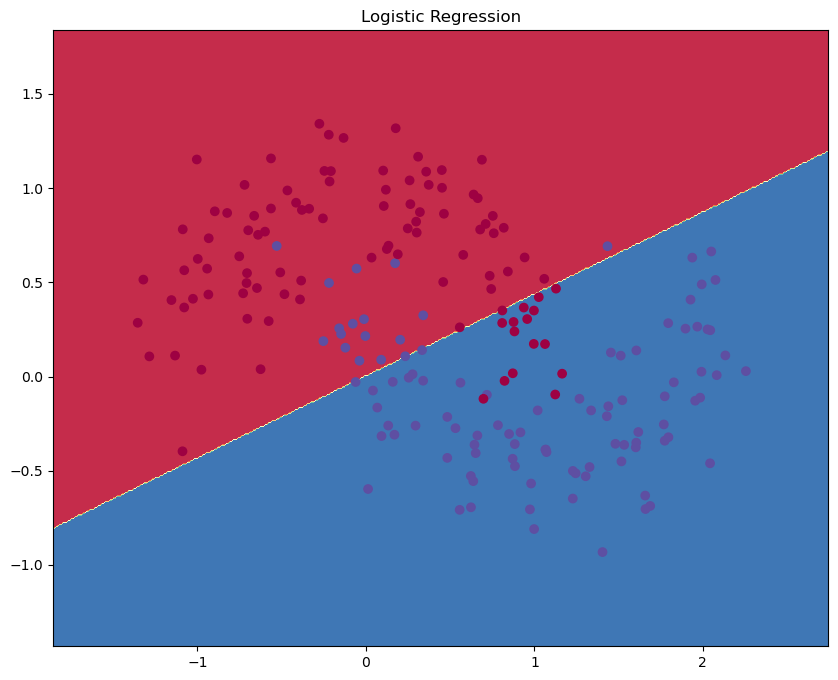

In [13]:
# Plot the decision boundary
plot_decision_boundary(lambda x: grid.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Training a Neural Network

In [7]:
# Define some useful values
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 500 # hiddien layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.1 # learning rate for gradient descent

In [8]:
num_examples

200

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. 
* The number of nodes in the input layer is determined by the the dimension of the predictor matrix. 
* The number of nodes in the output layer is determined by the number of classes. 
* The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:


<img src='./nn-3-layer-network.png' style='width: 50%'/>

### Choose the hidden layer dimension and activation function
* Choose the hidden layer dimensionality. 
    * The more nodes we put into the hidden layer the more complex functions we will be able fit. 
    * But setting hidden layers with higher dimensionality will be easily overfitting. 
    * We will play with the number of nodes in the hidden layer later on and see how it affects our output.
* Choose the *activation function* for our hidden layer
    * A nonlinear activation function is what allows us to fit nonlinear hypotheses.
    * Common chocies for activation functions are 
        * [tanh](https://reference.wolfram.com/language/ref/Tanh.html), 
        * [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)
        * [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).
    * Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), familiar with logistic function

### Forward propagation

* a bunch of matrix multiplications and the application of the activation function(s) we defined above. 
* Input: $x_{n\times 2}$
* Output: $\hat y_{n\times 2}$

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$


$$
\mathrm{softmax}(\mathbf{z})^{(i)} = \frac{e^{z^{(i)}}}{e^{z^{(1)}} + e^{z^{(2)}}}
$$

Where $x^{(i)}$ denotes the ith column of a matrix $X$

The softmax function ensures that each row (sample) of the output are in the range (0, 1) and sum to 1, making them suitable as probabilities.

* $z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. 
* $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. 
    * If we use 500 nodes for our hidden layer then 
        * $W_1 \in \mathbb{R}^{2\times500}$, 
        * $b_1 \in \mathbb{R}^{500}$, 
        * $W_2 \in \mathbb{R}^{500\times2}$, 
        * $b_2 \in \mathbb{R}^{2}$. 

#### Practice 2: Write a function for forward propagation

In [16]:
# Function to predict an output (0 or 1)
def predict(model, x):
    """
    Input: 
    * model: dictionary containing the model parameters
    * x: input data
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    ### start your code here
    # Forward propagation
    z1=x.dot(W1)+b1
    a1=np.tanh(z1)
    z2=a1.dot(W2)+b2
    exp_scores= np.exp(z2)
    probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
    prediction=np.argmax(probs,axis=1)
    ### end your code here

    return prediction, probs

In [17]:
# randomly initialize the weights, we will update them with gradient descent
np.random.seed(0)
W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) # avoid vanishing/exploding gradients
b1 = np.zeros((1, nn_hdim))
W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim) # avoid vanishing/exploding gradients
b2 = np.zeros((1, nn_output_dim))

model = {}
model['W1'] = W1
model['b1'] = b1
model['W2'] = W2
model['b2'] = b2

# Forward propagation
predictions, probs = predict(model, X)
print(predictions[:10]) # the first 10 predictions using the randomly initialized weights
print(probs[:10]) # the first 10 probabilities using the randomly initialized weights
print(y[:10]) # the first 10 true labels

[0 1 0 1 1 1 0 1 0 1]
[[0.5337928  0.4662072 ]
 [0.41334765 0.58665235]
 [0.51007757 0.48992243]
 [0.47544531 0.52455469]
 [0.45423148 0.54576852]
 [0.46073435 0.53926565]
 [0.52553407 0.47446593]
 [0.47754975 0.52245025]
 [0.52636921 0.47363079]
 [0.44190361 0.55809639]]
[0 1 1 0 1 1 0 1 0 1]


In [18]:
# Tips: indexing the predicted probabilities of the true class
print(probs[range(4), y[:4]])
# Also try print(probs[:4, np.array([0,1,0,1])])

[0.5337928  0.58665235 0.48992243 0.47544531]


### Loss function

We want to minimize the *loss function* by optimizing the model parameters. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{i =1}^N \sum_{j=1}^C y_{i,j} \log\hat{y}_{i,j}
\end{aligned}
$$



#### Practice 3: Write a function to calculate the loss

In [23]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    ### start your code here
    # Forward propagation to get the predictions
    z1=X.dot(W1)+b1
    a1=np.tanh(z1)
    z2=a1.dot(W2)+b2
    exp_scores= np.exp(z2)
    probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
    # Calculating the loss
    correct_logprobs=-np.log(probs[range(num_examples),y])
    data_loss=np.sum(correct_logprobs)
    ### end your code here
    
    data_loss /= num_examples
    
    
    return data_loss

In [24]:
loss = calculate_loss(model)
loss # your expected output

np.float64(0.640659416162574)

### Learning the Parameters

We want to learn the parameters by minimizing our loss function. 

We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. There are multiple types of gradiant descent:
* batch gradient descent with a fixed learning rate (Used in this lab)
* SGD (stochastic gradient descent)
* minibatch gradient descent

More details can be learned [here](https://cs231n.github.io/neural-networks-3/#update).

#### Practice 3: Calculate derivatives

Calculate the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$ using *backpropagation algorithm*.

Hint: 
1. see example [here](http://cs231n.github.io/optimization-2/)
2. See appendix for matrix derivative


Answer:
$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3/N  \\
& \frac{\partial{L}}{\partial{b_2}} = 1^T\delta_3/N\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2/N\\
& \frac{\partial{L}}{\partial{b_1}} = 1^T\delta_2/N \\
\end{aligned}
$$

#### Practice 4: Build model with backward propagation
Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [27]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation, repeat the same code as above
        ### start your code here
        z1=X.dot(W1)+b1
        a1=np.tanh(z1)
        z2=a1.dot(W2)+b2
        exp_scores= np.exp(z2)
        probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
        ### end your code here

        # Backpropagation, calculate dW1, db1, dW2, db2
        ### start your code here
        delta3=probs
        delta3[range(num_examples),y] -= 1
        dW2=(a1.T).dot(delta3)/num_examples
        db2=np.sum(delta3,axis=0,keepdims=True)/num_examples
        delta2=delta3.dot(W2.T)*(1-np.power(a1,2))
        dW1=np.dot(X.T,delta2)/num_examples
        db1=np.sum(delta2,axis=0,keepdims=True)/num_examples
        
        ### end your code here

        # Update parameters using gradient descent, e.g., W1 = W1 - epsilon * dW1
        # Predefined learning rate -- epsilon
        ### start your code here
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        ### end your code here
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.573469
Loss after iteration 1000: 0.233179
Loss after iteration 2000: 0.147290
Loss after iteration 3000: 0.100941
Loss after iteration 4000: 0.082691
Loss after iteration 5000: 0.075338
Loss after iteration 6000: 0.071973
Loss after iteration 7000: 0.070118
Loss after iteration 8000: 0.068935
Loss after iteration 9000: 0.068103
Loss after iteration 10000: 0.067479
Loss after iteration 11000: 0.066990
Loss after iteration 12000: 0.066595
Loss after iteration 13000: 0.066269
Loss after iteration 14000: 0.065995
Loss after iteration 15000: 0.065761
Loss after iteration 16000: 0.065558
Loss after iteration 17000: 0.065380
Loss after iteration 18000: 0.065223
Loss after iteration 19000: 0.065082


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

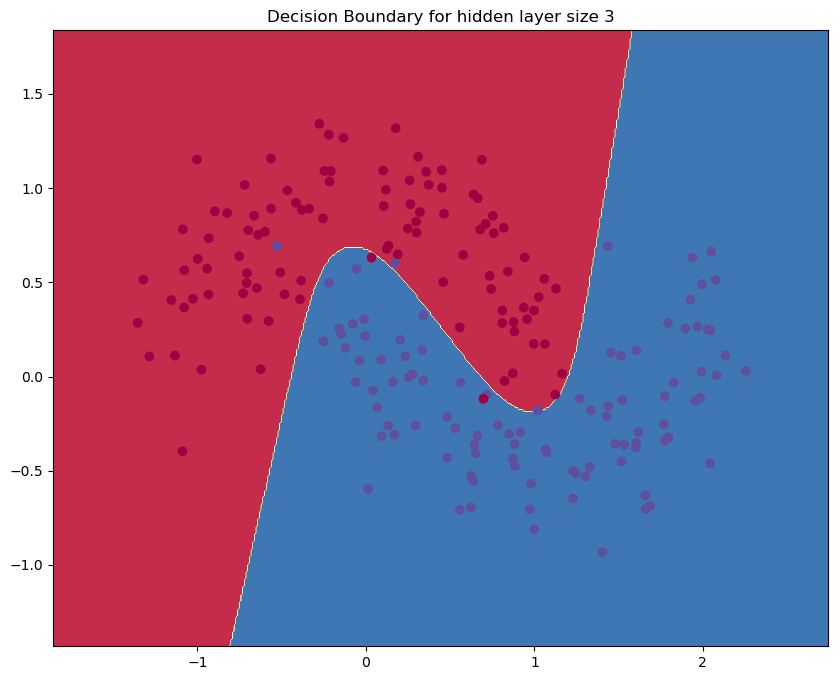

In [28]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x)[0])
plt.title("Decision Boundary for hidden layer size 3")

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


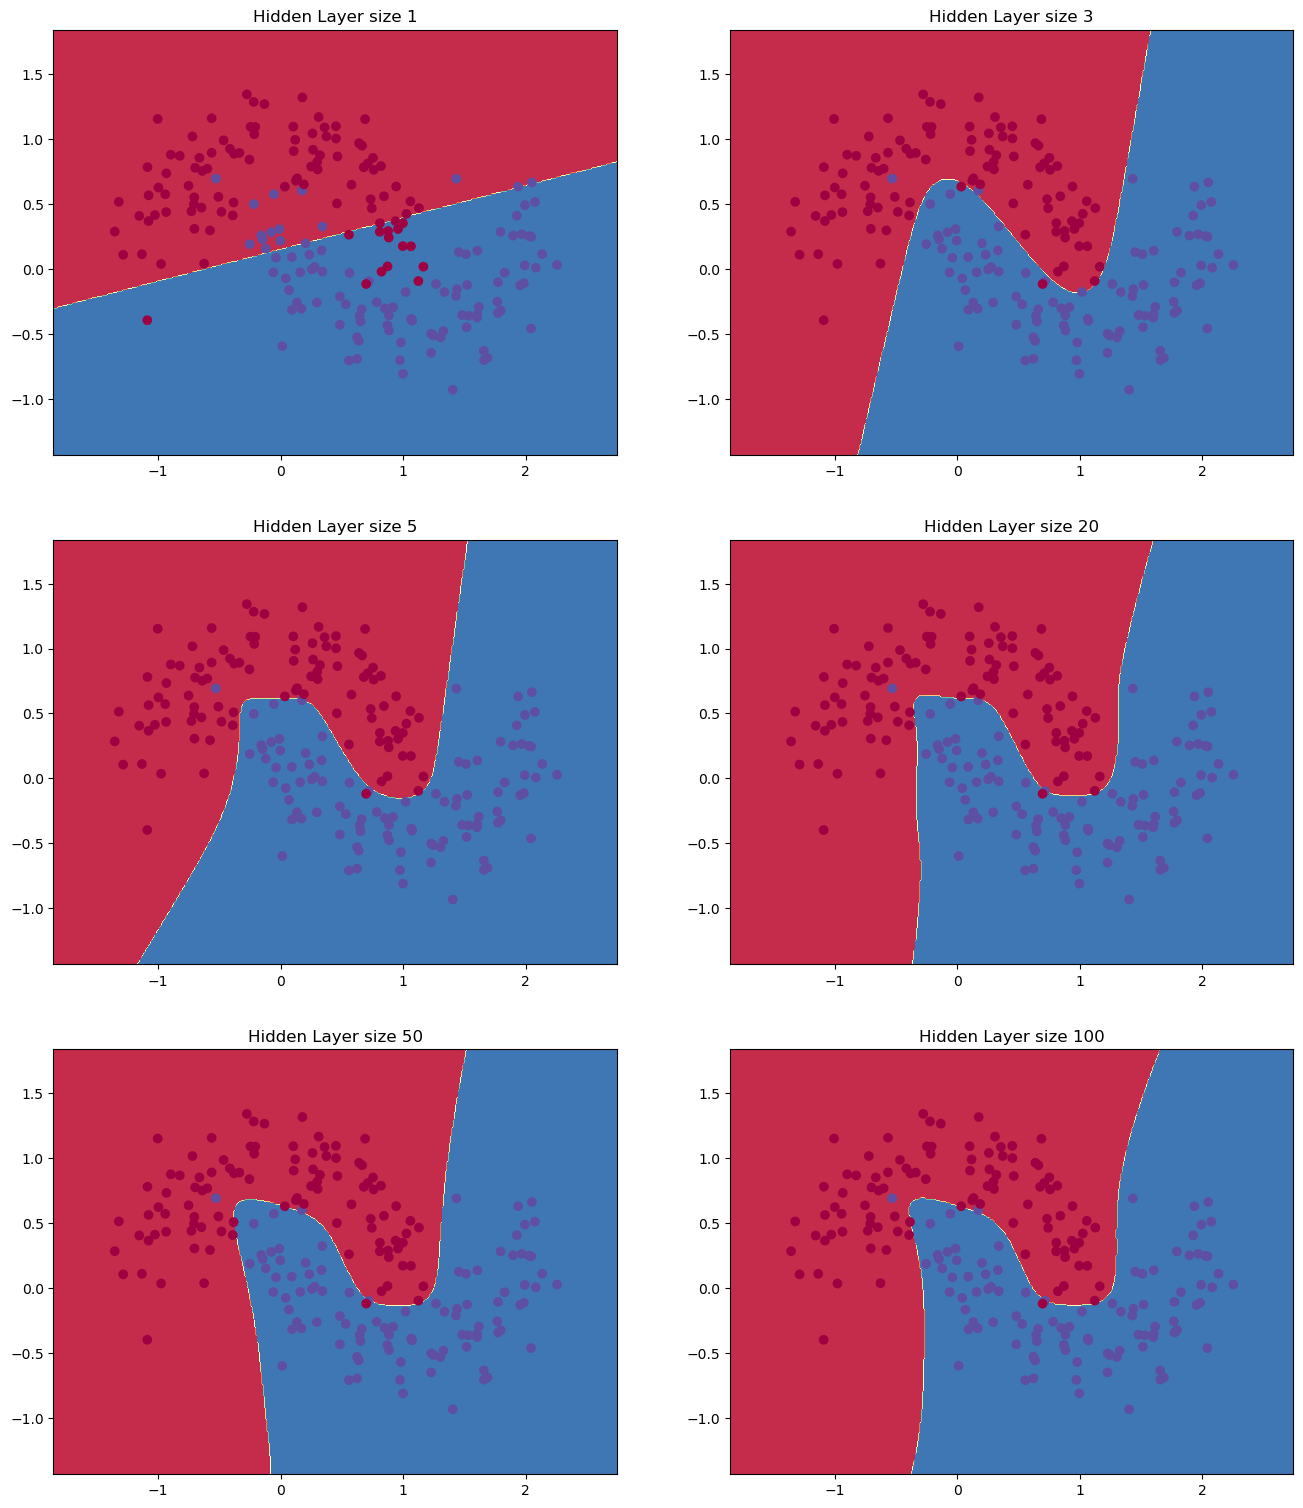

In [29]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 3, 5, 20, 50, 100]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x)[0])
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the correct size for hidden layer is a much more "economical" solution.

# Optional Exercises

Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.


# Use pytorch to build the 3-layer NN

In [32]:
# install pytorch
# !pip install torch, torchvision, torchaudio 
# check more details at https://pytorch.org/get-started/locally/

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        a1 = F.tanh(self.fc1(x))
        z2 = self.fc2(a1)
        return z2

# Initialize the model
model = Net()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')

# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors and wrap them in Variables
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Train the model
for epoch in range(20000):
    # Forward pass
    z2 = model(X_tensor)
    
    # Compute and print loss
    loss = criterion(z2, y_tensor)
    if epoch % 1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the decision boundary
def plot_decision_boundary_torch(X, y, model):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.argmax(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)).data.numpy(), axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

plot_decision_boundary_torch(X, y, model)

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision
ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


ModuleNotFoundError: No module named 'torch'

# Appendix: Matrix derivarives: 

1. **Scalar to 2D Vector**:

   Derivative of a scalar function $f(\mathbf{x})$ with respect to a 2D vector $\mathbf{x} \in \mathbb{R}^{1\times 2}$:

   $$\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}} = 
   \begin{bmatrix}
   \frac{\partial f}{\partial x_1} \;\frac{\partial f}{\partial x_2}
   \end{bmatrix}$$

2. **2D Vector to 2D Vector**:

   Derivative of a vector function $\mathbf{f}(\mathbf{x}) \in \mathbb{R}^{1\times 2}$ with respect to a 2D vector $\mathbf{x} \in \mathbb{R}^{1\times 2}$ results in a Jacobian matrix:

   $$\frac{\partial \mathbf{f}(\mathbf{x})}{\partial \mathbf{x}} = 
   \begin{bmatrix}
   \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
   \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
   \end{bmatrix}$$


3. **Linear relationship**

   Derivative of a linear vector function $\mathbf{z}=\mathbf{a}\mathbf{W}$ with respect to $\mathbf{W}$, where $a\in \mathbb{R}^{1\times d_a}$, and $W \in \mathbb{R}^{d_a\times d_z}$:

   $$\frac{\partial \mathbf{z}}{\partial \mathbf{W}}=\mathbf{a}^T$$

4. **Chain Rule for Matrix Derivatives**:

   Suppose $\mathbf{z} = f(\mathbf{y})$ and $\mathbf{y} = h(\mathbf{x})$, where $\mathbf{x} \in \mathbb{R}^{1\times d_x}, \mathbf{y}\in \mathbb{R}^{1\times d_y}, \mathbf{z} \in \mathbb{R}^{1\times d_z}$. The chain rule for derivatives is:

   $$\frac{\partial \mathbf{z}}{\partial \mathbf{x}}= \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}$$

Always check the dimension!